# Clasificación de preguntas de clientes - Santander

En Santander tenemos por misión contribuir al progreso de las personas y las empresas. Debido a ello buscamos constantemente nuevas formas de entender al cliente, con el objetivo de consolidar vínculos a largo plazo.

Nuestro equipo de Advanced Analytics & Machine Learning se encuentra en continua mejora de sus algoritmos y modelos. Basándonos en esta premisa, decidimos abrir nuestros datos e invitar a la comunidad a identificar nuevas formas de entender las preguntas y reclamos de nuestros clientes, utilizando un motor de NLU (Natural Language Understanding).

Esta competencia tiene como objetivo desarrollar un algoritmo de clasificación que, utilizando técnicas de NLP (Natural Language Processing), sea capaz de entender la intención de un cliente (target) al momento de realizar una pregunta (predictor) en alguno de los canales del Banco.

# Descripción
Se disponen de tres datasets:

- training.csv: reúne la información del caso, el mismo tiene dos columnas:
    - Pregunta: pregunta realizada por el cliente. (String)
    - Intención: intención de la pregunta realizada, contiene 350 intenciones aproximadamente. (String)

- test.csv: solo contiene la pregunta realizada por el cliente.

- primer_submit.csv: este archivo tiene el formato en el que se deben enviar las predicciones.

# Evaluación
La evaluación consta de dos partes:

1 - **Score de predicciones**: los resultados serán medidos utilizando la métrica **Balance Accuracy**. En el leaderboard se puede ver el mejor score público del total de submits de cada participante. El mismo se calcula con una porción de los datos de test. Metadata se reserva el score privado para la evaluación final.

El archivo con predicciones que se debe submitear debe esta en formato csv sin encabezado y debe contar de dos columnas. La primer columna corresponde al 'id' de la pregunta hecha por el cliente en el archivo de test. La segunda a la categoría predicha en formato de entero, es decir, si la predicción es cat_101 (string) debe reportar solamente 101 (int). Para ver un ejemplo puede mirar el archivo primer_submit en las solapa Datos.

2 - **Informe**: Al finalizar la competencia se pedirá a los primeros 10 competidores en el ranking de predicciones un informe adicional, donde se explique el modelo y la metodología aplicada. La nota la otorgará un jurado ad-hoc de especialistas en el tema evaluando el informe sobre el trabajo realizado con el análisis de contrastación entre los datos reales y los datos generados por los modelos.

Finalmente, el score total que determinará los ganadores se compondrá en un 70% por el score privado conseguido con la predicción medida con la métrica especificada y el 30% restante se sumará con el informe.

Importante: tanto Santander como Metadata se reservan el derecho a pedir el código para poder evaluar el modelo y evitar soluciones tramposas. En caso de que se le requiera el código a un participante y no lo envíe, será descalificado de forma inmediata.

In [1]:
import os
import sys
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re
from gensim.models import KeyedVectors
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from joblib import load, dump
from keras.metrics import categorical_accuracy
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LSTM,SpatialDropout1D, GRU, Bidirectional, TimeDistributed, BatchNormalization
import gc
from imblearn import FunctionSampler
from sklearn.utils import class_weight
import keras.backend as K
import fasttext

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
df = pd.read_csv('./train.csv', sep='|')

In [4]:
df.shape

(20104, 2)

In [5]:
df.head()

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342


In [6]:
df.isna().sum()

Pregunta     0
Intencion    0
dtype: int64

In [7]:
val_counts = pd.DataFrame(df.Intencion.value_counts())
val_counts.tail(5)

,Intencion
Cat_13,3
Cat_11,3
Cat_205,3
Cat_24,2
Cat_104,1


In [8]:
relevant = val_counts[val_counts.Intencion > 20].index
relevant.shape

(221,)

In [9]:
df = df[df['Intencion'] != 'Cat_104']

In [10]:
TEST_SPLIT = 0.15
FILTER_SIZES = [1,2,3]
NUM_FILTERS = 512
DROPOUT = 0.5
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 10

In [11]:
insurance_company_names = []
transform_dict = {
    'k':'que',
    'q':'que',
    'xq': 'por que',
    'wsp':'whatsapp',
    'wasap':'whatsapp',
    'watsap':'whatsapp',
    'hdp': 'hijo de puta',
    'vergüenza' : 'verguenza',
    'imbesil': 'imbecil',
    'imbesiles': 'imbeciles'
}
non_important_words = []

In [12]:
class text_preprocessor():
    
    def __init__(self, test_split = 0.2, pad_with = 'max_len'):
        '''
        Pad with can be: 'max_lenght', 'avg_lenght' or int number
        ''' 
        if (pad_with not in ('max_len','avg_len')) and (type(pad_with) is not int):
            raise Exception("ERROR: Pad with must be 'max_lenght', 'avg_lenght' or int type")
        self.tokenizer = Tokenizer()
        self.test_split = test_split
        self.pad_with = pad_with
        self.pad_text_to = None
        self.nlp = spacy.load('es_core_news_sm', disable=['ner','parser'])
        self.y_label_encoder = OneHotEncoder(sparse=False)
    
    def fit_transform(self, df):
        # Data Preparation
        x_text, y = self.make_dataset(df)
        
        # Build vocabulary
        if self.pad_with == 'max_len':
            max_text_lenght = max([len(x.split(" ")) for x in x_text])
            self.pad_text_to = max_text_lenght
        elif self.pad_with == 'avg_len':
            avg_text_lenght = int(np.mean([len(x.split(" ")) for x in x_text]))
            self.pad_text_to = avg_text_lenght
        elif type(self.pad_with) is int:
            self.pad_text_to = self.pad_with
        else:
            raise Exception("ERROR: Pad with must be 'max_lenght', 'avg_lenght' or int type")
        
        self.tokenizer.fit_on_texts(x_text)
        sequences =  self.tokenizer.texts_to_sequences(x_text)
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        print("Vocabulary Size : {}".format(vocab_size))
        x = pad_sequences(sequences, maxlen=self.pad_text_to) # Pad with 0.0 (default pad_sequences value)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=self.test_split, random_state=42,stratify=y)
        
        del x, y

        print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
        return x_train, y_train, vocab_size, word_index, x_test, y_test
   
    def transform(self, text):
        stripped = [s.strip() for s in text]
        clean = [self.clean_str(sent) for sent in stripped]
        sequences = self.tokenizer.texts_to_sequences(clean)
        x = pad_sequences(sequences, maxlen=self.pad_text_to)
        return x
    
    def get_padded_text_len(self):
        if self.pad_text_to is not None:
            return self.pad_text_to
        else:
            raise Exception("ERROR: pad_text_to is not set. Must fit before get_padded_text_len")
        
    def clean_str(self,string):
        string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
        string = re.sub(r",", " , ", string)
        string = re.sub(r"\.", " . ", string)
        string = re.sub(r"!", " ! ", string)
        string = re.sub(r"\(", " \( ", string)
        string = re.sub(r"\)", " \) ", string)
        string = re.sub(r"\?", " \? ", string)
        string = re.sub(r"\s{2,}", " ", string) #2 spaces
        string = re.sub(r'[^\w\s]|(.)(?=\1)', '', string) #repeated chars such as hhholaaa = hola
        string = self.strip_accents(string)
        #replace words according the transform_dict
        string = ''.join(transform_dict[w.lower()] if w.lower() in transform_dict else w for w in re.split(r'(\W+)', string))
        #remove insurance company names and non important words
        stop_words = insurance_company_names + non_important_words
        string = ''.join(w.lower() if w.lower() not in stop_words else '' for w in re.split(r'(\W+)', string))
        
        doc = self.nlp(string)
        #string = ' '.join([token.text if not token.is_stop else '' for token in doc])
        string = ' '.join([token.lemma_ if (not token.is_stop) & (token.is_alpha) & ~(token.is_digit or len(token.text) == 1) else '' for token in doc])
        
        return string.strip().lower()
    
    def strip_accents(self, text):

        try:
            text = unicode(text, 'utf-8')
        except NameError: # unicode is a default on python 3
            pass
        text = unicodedata.normalize('NFD', text)\
               .encode('ascii', 'ignore')\
               .decode("utf-8")
        return str(text)

    def make_dataset(self, df):
        x = df['Pregunta'].values
        y = df['Intencion']
        
        x = [s.strip() for s in x]
        x = [self.clean_str(sent) for sent in x]
        # labels
        y = y.str.extract('(\d+)')
        y = self.y_label_encoder.fit_transform(y)  
        return [x, y]
    
    def get_class_name(self, preds):
        return self.y_label_encoder.inverse_transform(preds)

In [13]:
processor = text_preprocessor(test_split = TEST_SPLIT, pad_with = 'max_len')

In [14]:
x_train, y_train, vocab_size, word_index, x_test, y_test = processor.fit_transform(df)

Vocabulary Size : 3992
Train/Test split: 17087/3016


In [15]:
texts_fixed_len = processor.get_padded_text_len()

In [16]:
print("All texts will be padded with {} words".format(texts_fixed_len))

All texts will be padded with 46 words


In [17]:
y_train.shape

(17087, 351)

In [18]:
wvecs = fasttext.load_model('./embeddings/cc.es.300.bin')
embeddings_vec_size = wvecs.get_dimension()

In [19]:
embedding_matrix = np.zeros((len(word_index) + 1, embeddings_vec_size))
for word, i in word_index.items():
    try:
        embedding_vector = wvecs.get_word_vector(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except:
        pass # words that are not found in embeddings are filled with all 0

In [51]:
inputs = Input(shape=(texts_fixed_len,), dtype='int32')
input_layer = Embedding(len(word_index) + 1,
                        embeddings_vec_size,
                        weights=[embedding_matrix],
                        input_length=texts_fixed_len,
                        trainable=False)(inputs)
input_layer = SpatialDropout1D(0.2)(input_layer)
i1 = Bidirectional(LSTM(embeddings_vec_size*2, return_sequences=True))(input_layer)
i2 = Conv1D(embeddings_vec_size, 2, activation='relu')(input_layer)
concatenated_tensor = Concatenate(axis=1)([GlobalAveragePooling1D()(i1), GlobalMaxPooling1D()(i2)])
concatenated_tensor = Dense(351*2, activation = 'relu')(concatenated_tensor)
concatenated_tensor = BatchNormalization()(concatenated_tensor)
concatenated_tensor = Dropout(0.1)(concatenated_tensor)
output = Dense(351, activation="softmax")(concatenated_tensor)

model = Model(inputs=inputs, outputs=output)

opt=Adam(lr=0.0003)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 46)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 46, 300)      1197600     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 46, 300)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 46, 1200)     4324800     spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

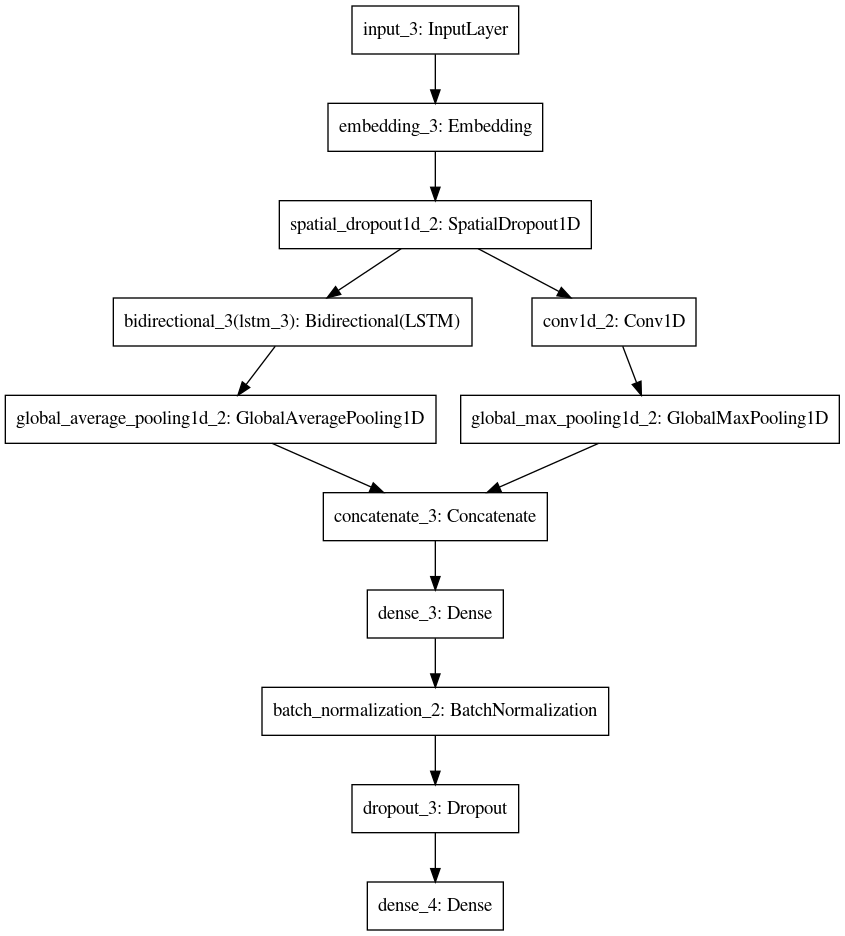

In [52]:
from keras.utils import plot_model
plot_model(model, to_file='cnn_rnn.png')

In [53]:
y_train.shape

(17087, 351)

In [54]:
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [45]:
%%time
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.6, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=3, verbose=1)

callbacks=[early_stopping]
model.fit(x_train, y_train,
          batch_size=1280,
          epochs=25,
          callbacks=callbacks,
          validation_data=(x_test, y_test),class_weight=d_class_weights)

Train on 17087 samples, validate on 3016 samples
Epoch 1/15
17087/17087 [==============================] - 11s 637us/step - loss: 0.2756 - accuracy: 0.8240 - val_loss: 1.2923 - val_accuracy: 0.6664
Epoch 2/15
17087/17087 [==============================] - 11s 631us/step - loss: 0.2732 - accuracy: 0.8263 - val_loss: 1.2975 - val_accuracy: 0.6674
Epoch 3/15
17087/17087 [==============================] - 11s 639us/step - loss: 0.2689 - accuracy: 0.8244 - val_loss: 1.2724 - val_accuracy: 0.6784
Epoch 4/15
17087/17087 [==============================] - 11s 642us/step - loss: 0.2640 - accuracy: 0.8323 - val_loss: 1.2754 - val_accuracy: 0.6741
Epoch 5/15
17087/17087 [==============================] - 11s 650us/step - loss: 0.2565 - accuracy: 0.8363 - val_loss: 1.2861 - val_accuracy: 0.6701
Epoch 6/15
17087/17087 [==============================] - 11s 656us/step - loss: 0.2510 - accuracy: 0.8355 - val_loss: 1.2704 - val_accuracy: 0.6767
Epoch 7/15
17087/17087 [==============================] -

In [46]:
preds = model.predict(x_test)

In [47]:
preds.argmax(axis=-1)

array([207, 219, 284, ..., 297, 131,  69])

In [48]:
y_test.argmax(axis=1)

array([208, 219, 284, ..., 297, 131,  52])

In [49]:
processor.get_class_name(y_test)

array([['294'],
       ['303'],
       ['39'],
       ...,
       ['50'],
       ['223'],
       ['151']], dtype=object)

In [50]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test.argmax(axis=1), preds.argmax(axis=-1))

0.6388375808378817

In [ ]:
val = pd.read_csv('./test_santander.csv', sep=',')

In [ ]:
val_prep = processor.transform(val.Pregunta.values)

In [ ]:
val_prep.shape

In [ ]:
val_preds = model.predict(val_prep)

In [ ]:
val_preds.shape

In [ ]:
processor.get_class_name(val_preds).flatten()

In [ ]:
subm = pd.DataFrame({'id':val.id.values, 'pred': processor.get_class_name(val_preds).flatten()})

In [ ]:
subm.to_csv('cnn_rnnSpatialDropout1D(0.2)(input_layer).csv',header=False, index=False)